# Generate graphs for Reliability by ROI size

## Load everything

In [43]:
import numpy as np 
import nibabel as nib
from nilearn import plotting,image
import pandas as pd 
import os 
from os.path import join, exists, split
import numpy as np
from scipy.stats import ttest_1samp
import scipy.ndimage
from statsmodels.stats.multitest import fdrcorrection

outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/'
homedir = split(os.getcwd())[0]
datadir = '/Users/danieljanini/Documents/Thesis/miniblock/'
presdir = join(homedir, 'Behavior', 'designmats')

subs = ["01", "02", "03", "04", "05", "06", "07", "08", "10", "11", "12", "13", "14", "15", "17", "18", "19"] # excluded participants 9 and 16
smooths = ["unsmoothed", "sm_2_vox"]
runtypes = ['miniblock', "er", "sus"]
splits = range(1,11)

results = []

for sub in subs:
    for smoothing in smooths:

        results_glmsingle = dict()
        results_glmsingle['typed'] = np.load(join(outdir,'localizer',f'sub-{sub}',f'{smoothing}_sub-{sub}_localizer/TYPED_FITHRF_GLMDENOISE_RR.npy'), allow_pickle=True).item()
        betas = results_glmsingle['typed']['betasmd']

        brain_mask = image.load_img(join(datadir, 'derivatives', f'sub-{sub}', 'func', f'sub-{sub}_task-func_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
        mask = brain_mask.get_fdata()

        masked_betas = betas[mask.astype(bool)]

        # Initialize result arrays
        t_vals = np.full(masked_betas.shape[0], np.nan)
        p_vals = np.full(masked_betas.shape[0], np.nan)

        # Iterate over only valid voxels
        it = np.ndindex(masked_betas.shape[0])
        for idx in it:
            t, p = ttest_1samp(masked_betas[idx], popmean=0)
            t_vals[idx] = t
            p_vals[idx] = p

        # 1. Sort voxel t-values in descending order
        sorted_indices = np.argsort(t_vals)[::-1]  # highest first

        # 2. Prepare dictionary for masks
        top_voxel_masks = {}

        # 3. Define your step sizes
        steps = np.arange(200, 50001, 50)  # 50, 100, ..., 50000

        # 4. Create a binary mask for each step
        for step in steps:
            mask_step = np.zeros_like(t_vals, dtype=int)
            top_indices = sorted_indices[:step]  # get top N voxels
            mask_step[top_indices] = 1  # mark them
            top_voxel_masks[step] = mask_step

        for runtype in runtypes:
            # Load mask
            #brain_mask_path = join(datadir, 'derivatives', f'sub-{sub}', 'anat', f'visual_voxels_mask_{smoothing}.nii.gz')
        
            split_results = []
            for split in splits:

                reliability_filename = join(outdir,'reliability', f'sub-{sub}', f'{smoothing}_sub-{sub}_{runtype}_reliability_map_split_{split}.nii.gz')

                if os.path.exists(reliability_filename):
                    reliability_img = nib.load(reliability_filename)
                    reliability_data = reliability_img.get_fdata()
                    # Create a full-size (brain-sized) mask of zeros
                    full_mask_shape = mask.shape
                    brain_size = np.prod(full_mask_shape)

                    # Build an index mapping from masked (1D) back to brain (3D)
                    brain_indices = np.where(mask.astype(bool))

                    for step, mask_step in top_voxel_masks.items():
                        # Start with zeros in brain space
                        new_brain_mask = np.zeros(full_mask_shape, dtype=int)
                        # Fill selected voxel locations
                        new_brain_mask[brain_indices] = mask_step


                        masked_reliability_values = reliability_data[new_brain_mask.astype(bool)]
                        median_reliability_split = np.nanmedian(masked_reliability_values)
                        mean_reliability_split = np.nanmean(masked_reliability_values)
                        

                        split_results.append({
                            "subject": sub,
                            "runtype": runtype,
                            "smoothing": smoothing,
                            "median_reliability": median_reliability_split,
                            "mean_reliability": mean_reliability_split,
                            "mask_size": step,
                            "split": split
                        })
                else:
                    print(f"Missing file: {reliability_filename}")
            split_df = pd.DataFrame(split_results)

            # Now group by mask_size and average across splits
            aggregated = split_df.groupby(["subject", "runtype", "smoothing", "mask_size"]).agg({
                "median_reliability": "mean",
                "mean_reliability": "mean"
            }).reset_index()

            # Now store the aggregated results
            results.append(aggregated)

df = pd.concat(results, ignore_index=True)

/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_64987/3784715550.py:90: RuntimeWarning: All-NaN slice encountered
  median_reliability_split = np.nanmedian(masked_reliability_values)
/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_64987/3784715550.py:91: RuntimeWarning: Mean of empty slice
  mean_reliability_split = np.nanmean(masked_reliability_values)
/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_64987/3784715550.py:90: RuntimeWarning: All-NaN slice encountered
  median_reliability_split = np.nanmedian(masked_reliability_values)
/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_64987/3784715550.py:91: RuntimeWarning: Mean of empty slice
  mean_reliability_split = np.nanmean(masked_reliability_values)
/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_64987/3784715550.py:90: RuntimeWarning: All-NaN slice encountered
  median_reliability_split = np.nanmedian(masked_reliability_values)
/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/i

In [46]:
df.to_csv('/Users/danieljanini/Documents/Thesis/Code/Reliability/reliability_roi_size.csv', index=False)

In [47]:
df = pd.read_csv('/Users/danieljanini/Documents/Thesis/Code/Reliability/reliability_roi_size.csv')


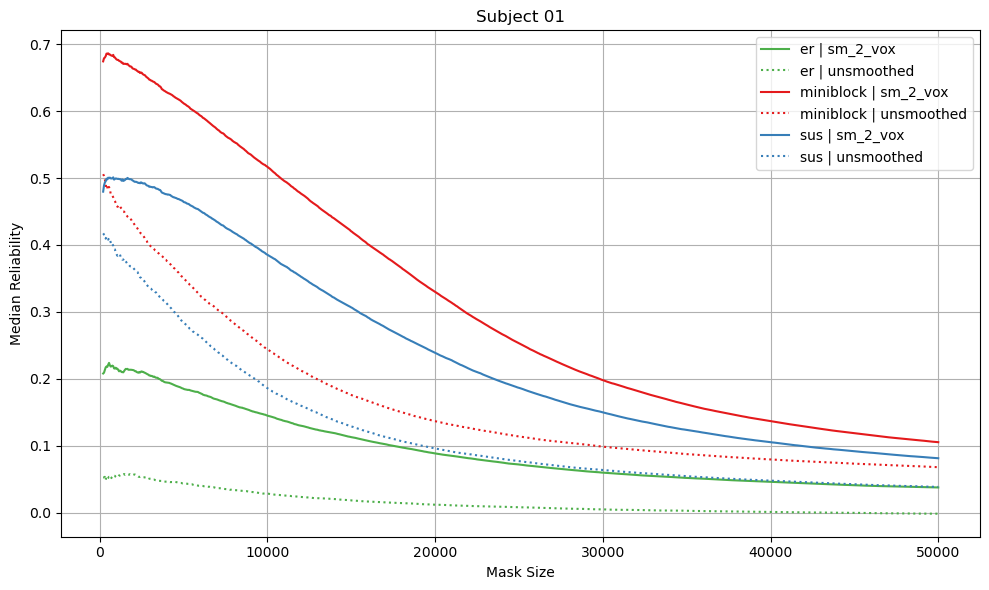

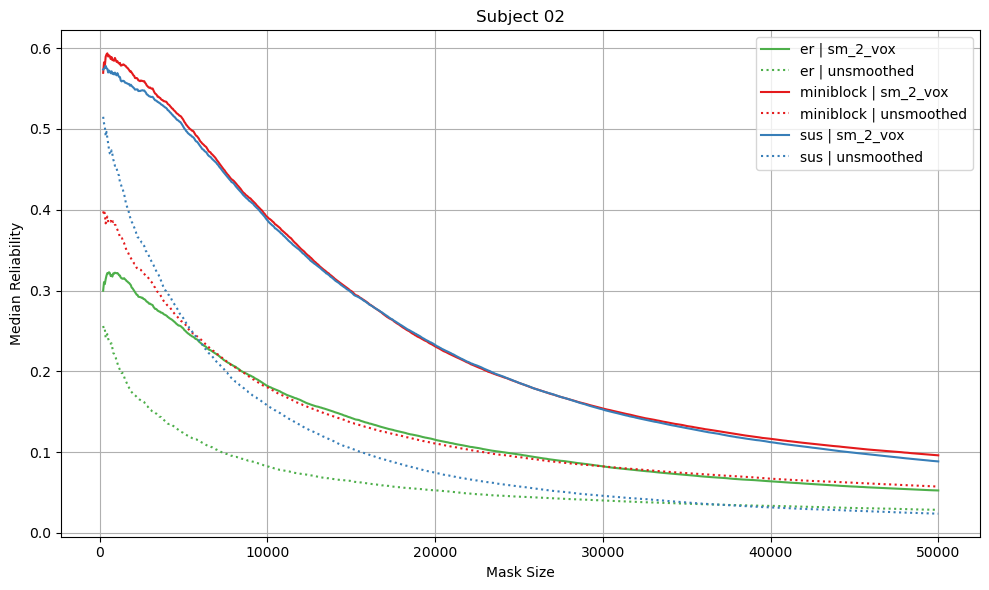

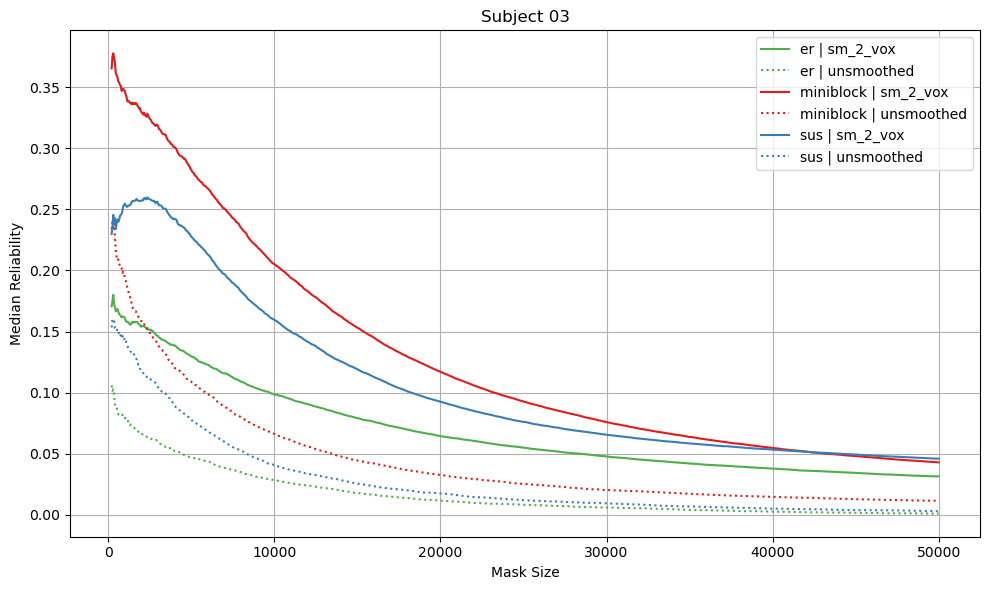

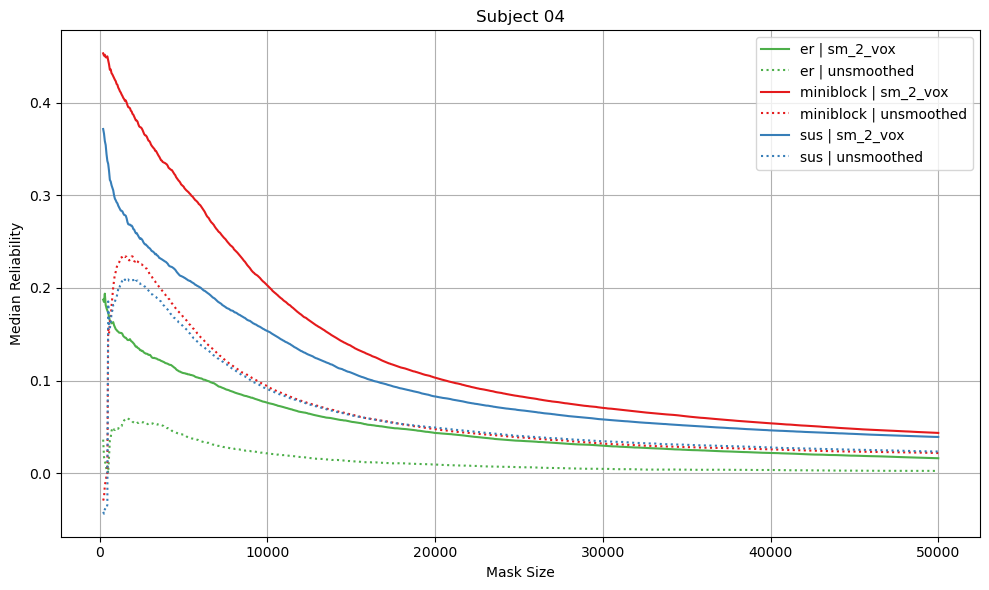

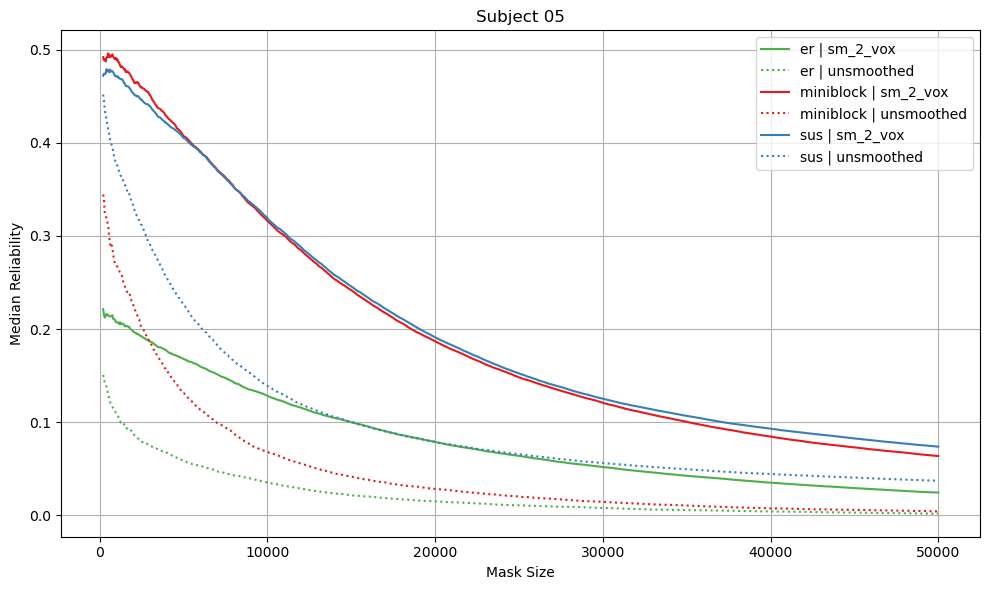

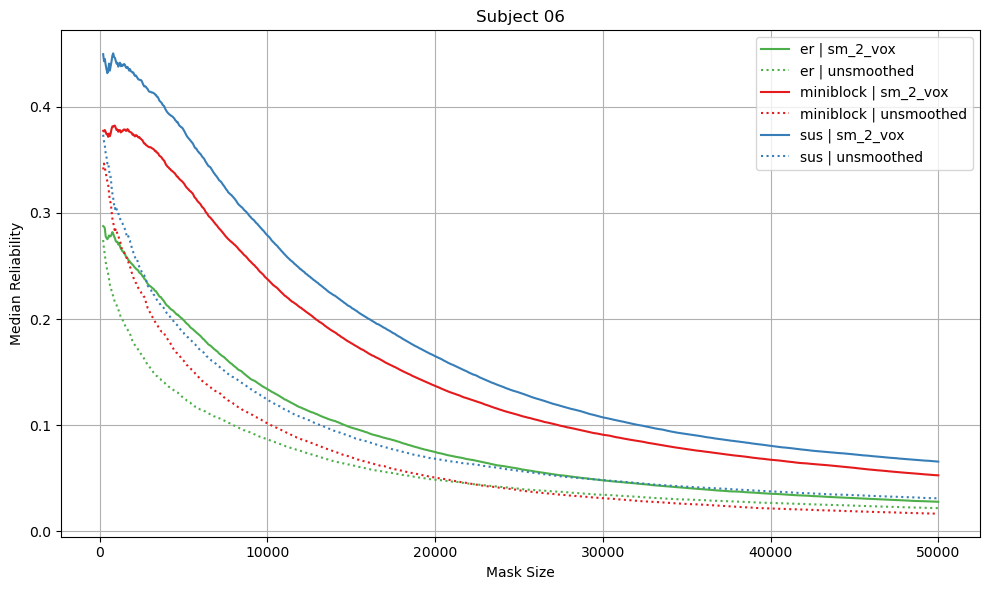

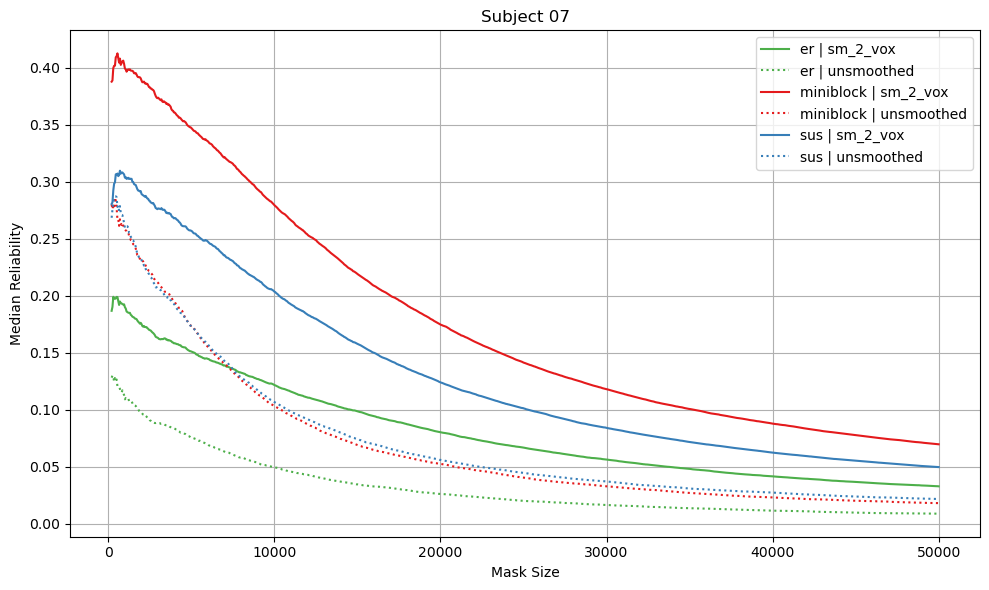

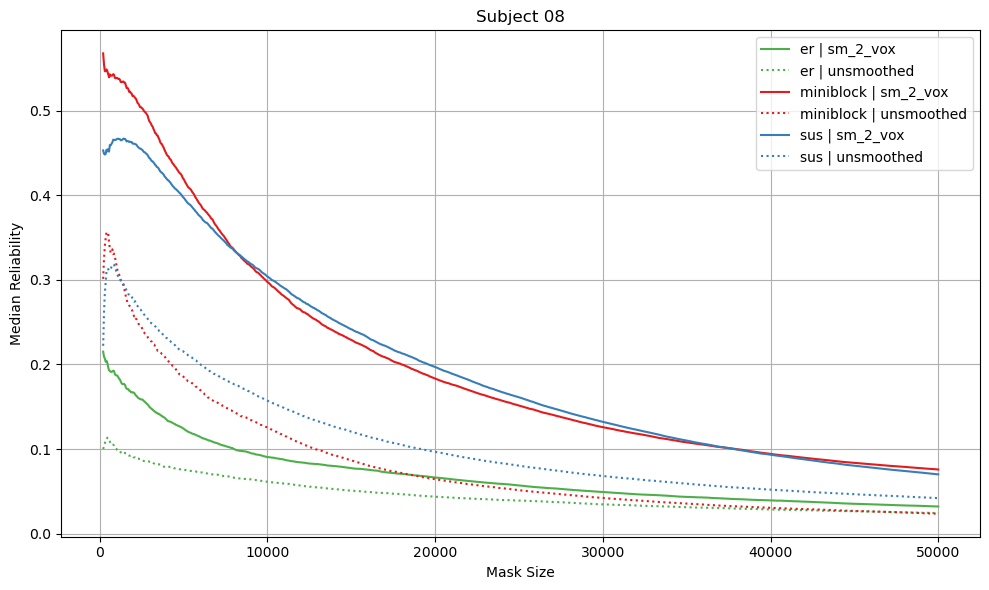

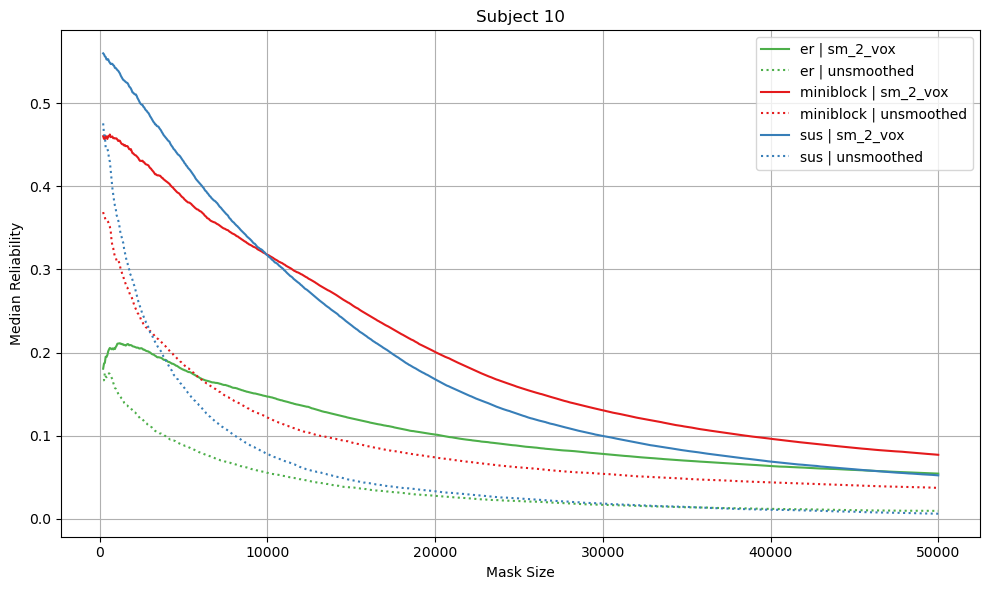

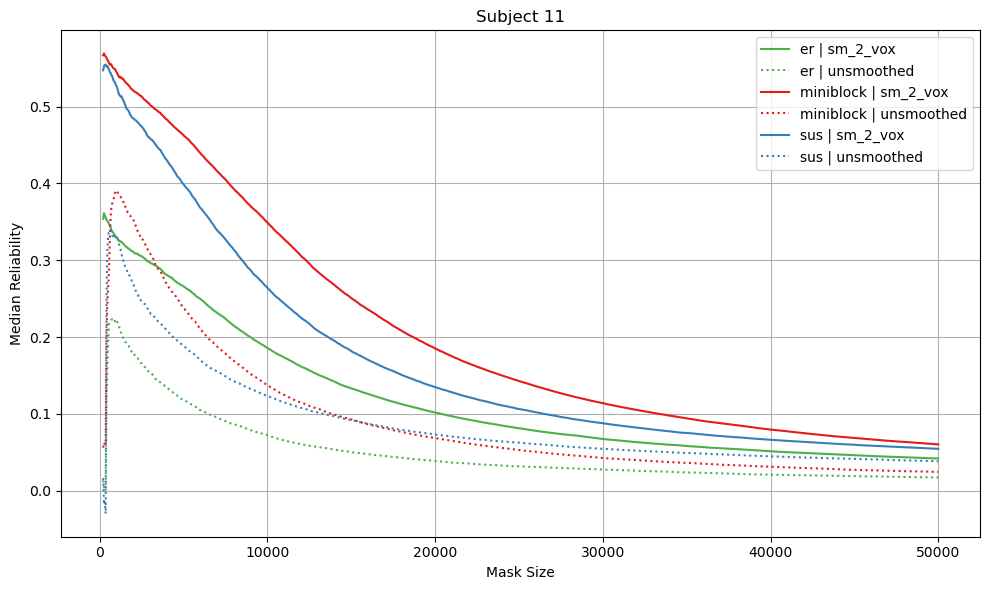

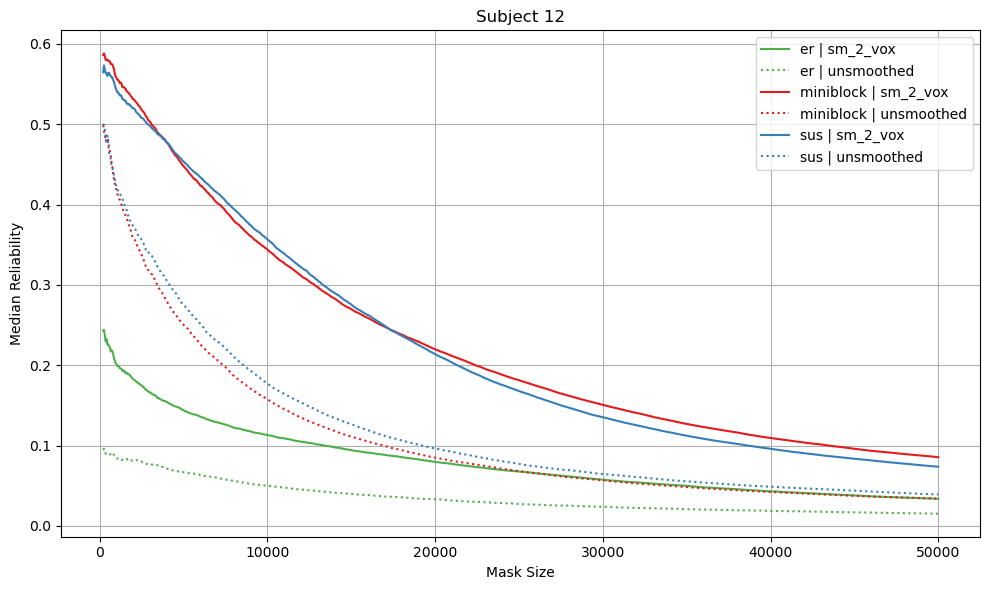

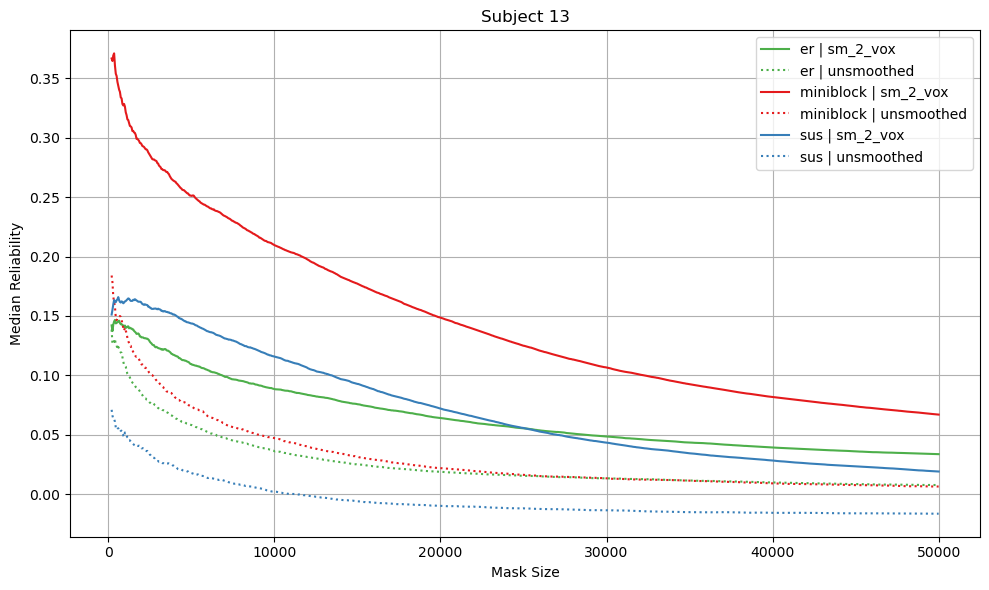

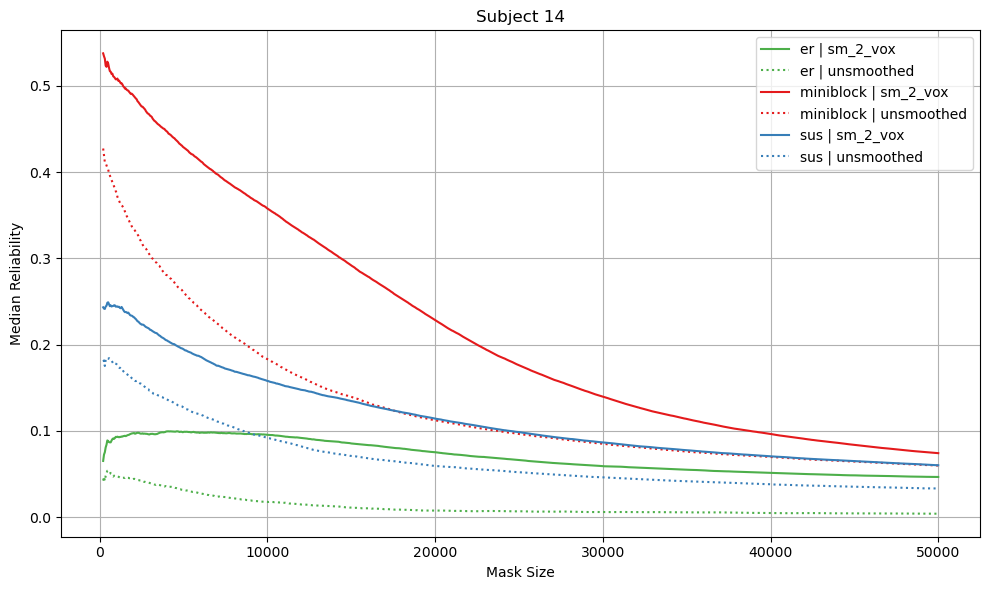

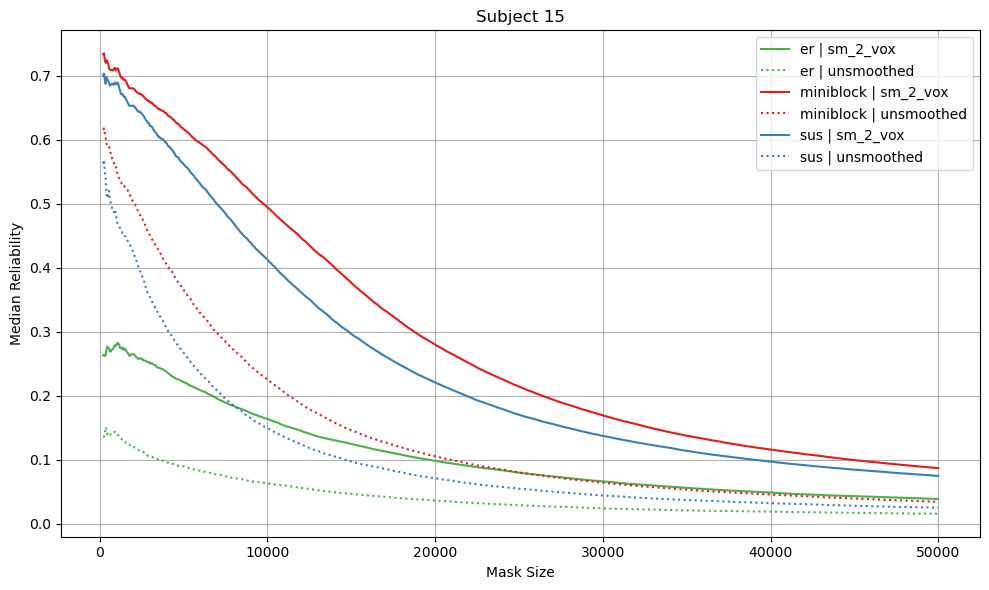

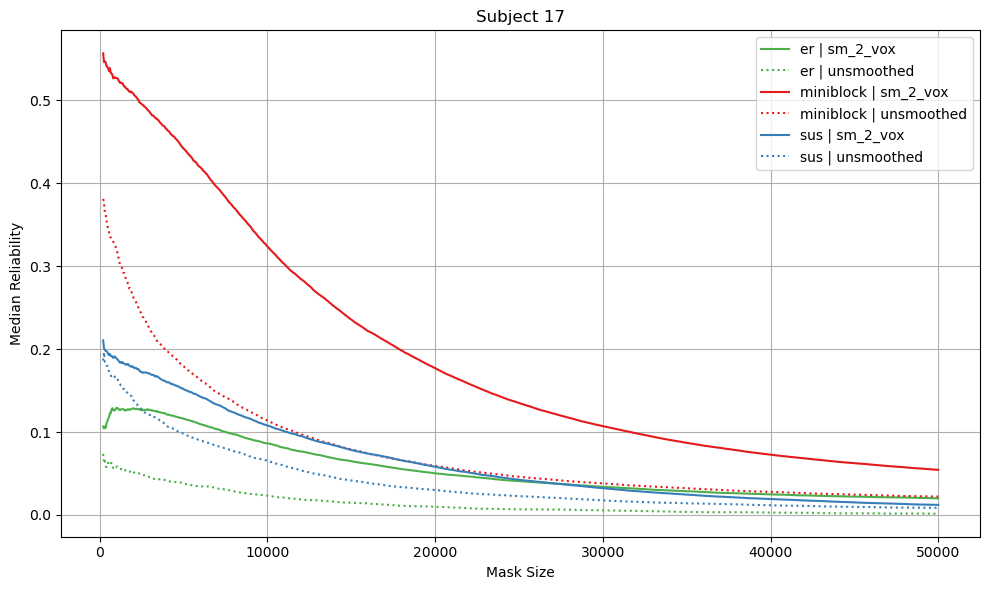

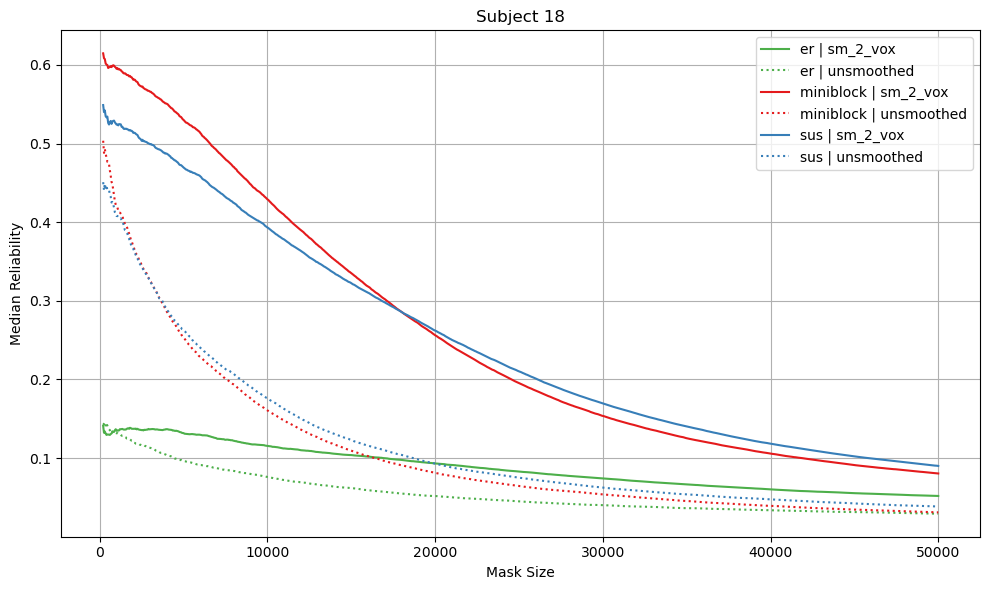

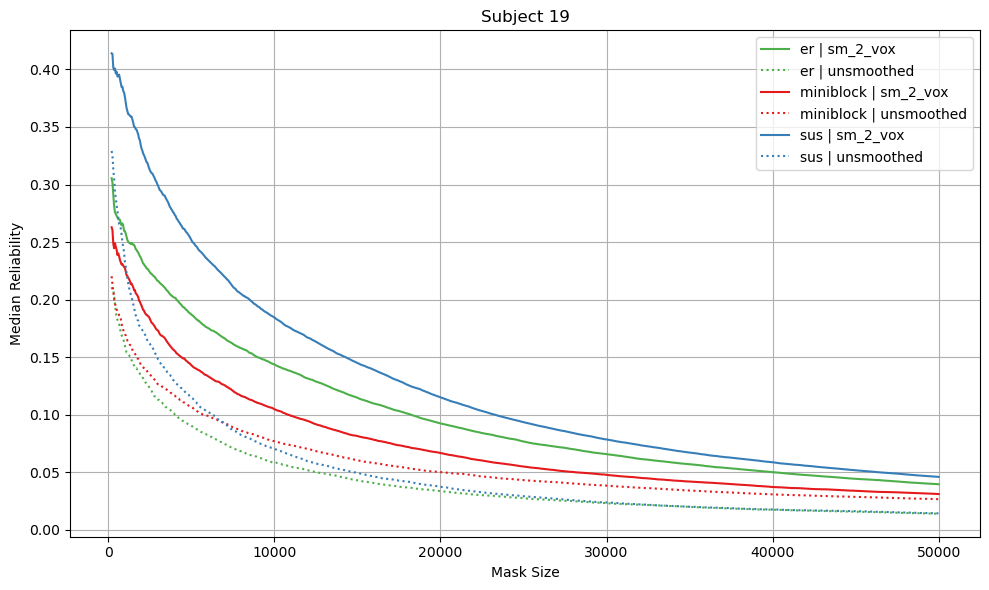

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

steps = np.arange(200, 50001, 50) 

colors = sns.color_palette("Set1", n_colors=3)
smoothing_to_linestyle = {
    'sm_2_vox': '-', 
    'unsmoothed': ':'
}

# Define mapping from runtype/condition to color
runtype_to_color = {
    'miniblock': colors[0], 
    'sus': colors[1], 
    'er': colors[2]
}

subs = df["subject"].unique() # excluded participants 9 and 16
smooths = ["unsmoothed", "sm_2_vox"]
runtypes = ['miniblock', "er", "sus"]

for sub in subs:
    plt.figure(figsize=(10, 6))
    sub_df = df[df['subject'] == sub]
    
    if sub_df.empty:
        print(f"No data for subject {sub}")
        continue

    for (runtype, smoothing), group in sub_df.groupby(['runtype', 'smoothing']):
        if group.empty:
            continue
        
        linestyle = smoothing_to_linestyle.get(smoothing, '-')
        color = runtype_to_color.get(runtype, 'black')
        label = f"{runtype} | {smoothing}"
        
        group_sorted = group.sort_values('mask_size')  # Important: x-axis must be sorted
        
        plt.plot(group_sorted['mask_size'], group_sorted['median_reliability'],
                 label=label, linestyle=linestyle, color=color)

    plt.xlabel('Mask Size')
    plt.ylabel('Median Reliability')
    plt.title(f'Subject {sub}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()